In [1]:
import logging
import warnings

import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple

import astropy.units as u

from astropy.utils.exceptions import AstropyWarning
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.wcs import WCS
from astropy.io import fits

from astropy.visualization import imshow_norm
from astropy.visualization import ZScaleInterval, LinearStretch

from astroquery.vizier import Vizier

from lsst.pipe.tasks.characterizeImage import CharacterizeImageConfig, CharacterizeImageTask

from lsst.summit.utils.astrometry import CommandLineSolver
from lsst.summit.utils.utils import starTrackerFileToExposure

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### Process exposures and run them through astrometry.net 

In [2]:
# Control logging level

logging.basicConfig()

logger = logging.getLogger("lsst.afw.image.MaskedImageFitsReader")
logger.setLevel(logging.ERROR)
logger = logging.getLogger("lsst.summit.utils.utils")
logger.setLevel(logging.ERROR)
logger = logging.getLogger("lsst.characterizeImage")
logger.setLevel(logging.ERROR)


In [3]:
# Configure the image task

snr = 5
minPix = 25

charConfig = CharacterizeImageConfig()
charConfig.doMeasurePsf = False
charConfig.doApCorr = False
charConfig.doDeblend = False
charConfig.repair.doCosmicRay = False
charConfig.doNormalizedCalibration= False

charConfig.detection.minPixels = minPix
charConfig.detection.thresholdValue = snr
charConfig.detection.includeThresholdMultiplier = 1
charConfig.detection.thresholdType = "stdev"

#charConfig.repair.doCosmicRay = True
#charConfig.repair.doInterpolate = True   

# fit background with the most simple thing possible as we don't need
# much sophistication here. weighting=False is *required* for very
# large binSizes.
charConfig.background.algorithm = "CONSTANT"
charConfig.background.approxOrderX = 0
charConfig.background.approxOrderY = -1
#charConfig.background.binSize = max(exposure.getWidth(), exposure.getHeight())
charConfig.background.binSize = max(3384, 2704)
charConfig.background.weighting = False

# set this to use all the same minimal settings as those above
charConfig.detection.background = charConfig.background

charTask = CharacterizeImageTask(config=charConfig)

In [4]:
# Get the Exposures from the files

# Setup on the summit
#home_dir = '/home/cwalter'
#lfa_dir = '/project/GenericCamera'
#ref_cat_dir = '/project/shared/ref_cats/astrometry_net/'

# Setup at USDF
home_dir = '/sdf/home/c/cwalter'
lfa_dir = '/sdf/home/c/cwalter/LFA'
ref_cat_dir = '/sdf/data/rubin/shared/refcats/astrometry_net_data/'

st_meta = namedtuple("ST_ids", "camera, y, m, d, seq_id")

exposure_list = [
    # Narrow
    st_meta(102, 2024, 4, 22, 23),
    st_meta(102, 2024, 4, 22, 24),
    st_meta(102, 2024, 4, 22, 25),
    st_meta(102, 2024, 4, 22, 26),
    st_meta(102, 2024, 4, 22, 27),

    st_meta(102, 2024, 4, 23, 26),
    st_meta(102, 2024, 4, 23, 27),
    st_meta(102, 2024, 4, 23, 28),
    st_meta(102, 2024, 4, 23, 29),
    st_meta(102, 2024, 4, 23, 30),
    
    # Fast
    #st_meta(103, 2024, 4, 23, 20)
]

In [5]:
for f in exposure_list:

    obs_id= f'GC{f.camera}_O_{f.y}{f.m:02d}{f.d:02d}_{f.seq_id:06d}'
    star_tracker_filename = f'{lfa_dir}/{f.camera}/{f.y}/{f.m:02d}/{f.d:02d}/{obs_id}.fits'
    print(f'Processing {obs_id}')
    
    exposure = starTrackerFileToExposure(star_tracker_filename)

    # Match the image to astronometry.net

    # Find the sources.
    char_result = charTask.run(exposure)
    char_result_table = char_result.sourceCat.asAstropy()

    # Pass the list of sources into local astrometry.net installation and solve
    catalog = char_result.sourceCat
    solver = CommandLineSolver(ref_cat_dir)
    result = solver.run(exposure, catalog, True)

    # Get the new WCS
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=AstropyWarning)
        anet_hdu_list = fits.open(result.wcsFile)
        wcs = WCS(anet_hdu_list[0].header)

    # Write a new FITS file with the WCS
    with fits.open(star_tracker_filename) as exposure_hdu_list: 

        star_tracker_header = exposure_hdu_list[1].header
        astrometry_net_header = anet_hdu_list[0].header

        sep_card = ('COMMENT', '--Start of Astrometry.net WCS solution--')
        star_tracker_header.append(sep_card)
        star_tracker_header.extend(astrometry_net_header, end=True)

        exposure_hdu_list.writeto(f'{home_dir}/processed-fits/{obs_id}.fits', overwrite=True)

Processing GC102_O_20240422_000023
lsst.afw.image.MaskedImageFitsReader WARN: Expected extension type not found: IMAGE
Fitting image with 184 sources of which 184 made it into the fit
Fitting code ran in 0.79 seconds
Processing GC102_O_20240422_000024
lsst.afw.image.MaskedImageFitsReader WARN: Expected extension type not found: IMAGE
Fitting image with 184 sources of which 184 made it into the fit
Fitting code ran in 0.78 seconds
Processing GC102_O_20240422_000025
lsst.afw.image.MaskedImageFitsReader WARN: Expected extension type not found: IMAGE
Fitting image with 187 sources of which 187 made it into the fit
Fitting code ran in 0.78 seconds
Processing GC102_O_20240422_000026
lsst.afw.image.MaskedImageFitsReader WARN: Expected extension type not found: IMAGE
Fitting image with 190 sources of which 190 made it into the fit
Fitting code ran in 0.79 seconds
Processing GC102_O_20240422_000027
lsst.afw.image.MaskedImageFitsReader WARN: Expected extension type not found: IMAGE
Fitting image

### Take the last catalog and overlay it with SAO catalog sources to see things are resasonable.

In [6]:
# Take the sources and put them into a table including sky coordinates from WCS

pixel_x = catalog.getColumnView().getX()
pixel_y = catalog.getColumnView().getY()
object_fluxes = catalog['base_CircularApertureFlux_3_0_instFlux']
sky_coordinates = wcs.pixel_to_world(pixel_x, pixel_y)

image_object_table = Table([pixel_x, pixel_y, sky_coordinates.ra, sky_coordinates.dec, object_fluxes], 
names=('x','y','_RAJ2000', '_DEJ2000', 'flux'))

image_object_table.sort('flux', reverse = True)
selected_sources = image_object_table
selected_sources[:10]

x,y,_RAJ2000,_DEJ2000,flux
,,deg,deg,
float64,float64,float64,float64,float64
956.9906964902918,1614.6583340818145,144.0175865264376,4.514279633496021,240086.484375
1249.402579643413,477.3356500360901,144.19228690457473,4.9508175924579625,134316.109375
1488.9696851615738,1627.6109953675211,143.84214322327747,4.635589198246531,70704.7734375
2652.665871152247,584.0453296198639,143.71204605018298,5.247207272730102,67798.7109375
2523.5716644730933,2158.590214649697,143.381146697275,4.707622328868479,48539.11328125
1511.3457060537585,344.6671078002052,144.1388545107587,5.05549715723319,41041.35546875
2380.7076337841363,1177.3953589162297,143.65965798475338,4.991326662236628,38682.5078125
1837.7436053081626,1509.013856361761,143.75717238614806,4.756162256500836,36387.8828125


In [7]:
# Match those sources to the The SAO J2000.0 catalogue
matched_stars = Vizier(catalog = 'I/131A').query_region(selected_sources, radius="30s", inner_radius="1s")[0]
matched_stars

_q,SAO,delFlag,RAB1950,pmRA,DEB1950,pmDE,Pmag,Vmag,SpType,_RA.icrs,_DE.icrs
,,,,s / a,,arcsec / a,mag,mag,,,
int32,int32,str1,str12,float32,str12,float32,float32,float32,str3,str12,str12
1,117798,,09 33 27.565,-0.0013,+04 44 21.09,-0.023,--,7.7,K2,09 36 04.452,+04 30 52.50
2,117805,,09 34 09.122,-0.0015,+05 10 31.93,-0.007,--,8.5,K5,09 36 46.288,+04 57 02.35
3,117790,,09 32 45.275,-0.0017,+04 51 33.28,-0.017,--,8.7,K0,09 35 22.239,+04 38 06.82
4,117781,,09 32 13.716,-0.0045,+05 28 17.96,-0.060,--,8.7,K0,09 34 50.980,+05 14 50.72
5,117770,,09 30 54.436,-0.0005,+04 55 48.43,-0.020,--,8.8,K2,09 33 31.547,+04 42 26.65
6,117803,,09 33 55.985,0.0007,+05 16 50.64,-0.030,--,8.7,F5,09 36 33.338,+05 03 20.47
7,117776,,09 32 01.224,-0.0026,+05 12 50.06,0.008,--,8.8,G0,09 34 38.407,+04 59 26.76
8,117785,,09 32 24.657,-0.0007,+04 58 45.79,-0.003,--,8.8,A2,09 35 01.762,+04 45 20.92


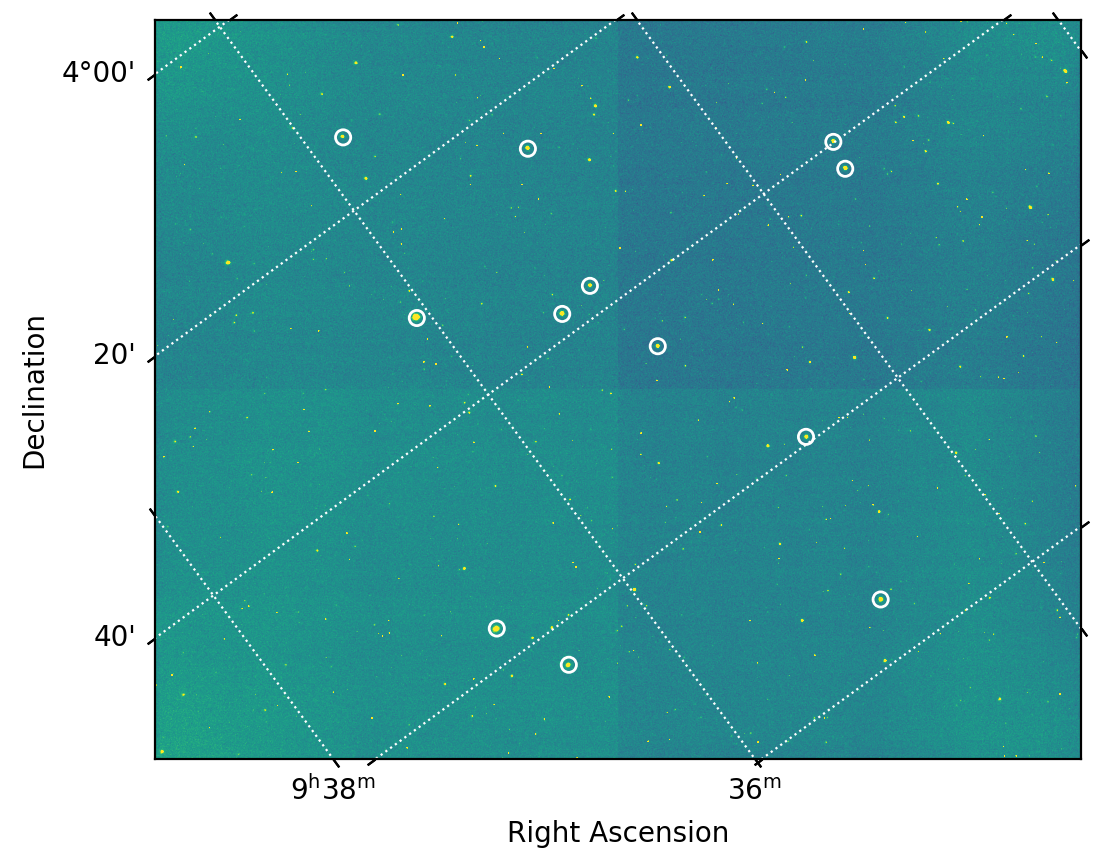

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

wcs_axis = plt.subplot(projection=wcs)

star_ra = matched_stars['_RA.icrs']
star_dec = matched_stars['_DE.icrs']
star_coords = SkyCoord(star_ra, star_dec, unit=(u.hourangle, u.deg),frame='icrs')

# Display Image
image = exposure.image.array
imshow_norm( image, origin='lower', interval=ZScaleInterval(), stretch=LinearStretch() )

# Overlay matching stars
wcs_axis.scatter(star_coords.ra, star_coords.dec, transform=wcs_axis.get_transform('fk5'), s=30,
           edgecolor='white', facecolor='none')

plt.grid(color='white', ls='dotted')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')